In [4]:
# Imports
import subprocess
import os
from joblib import Parallel, delayed
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
dir = "1cx2-cox2"
abbr = "cox2"
receptor = "1CX2"  # prefix of the receptor file
!gunzip $dir/$abbr-decoys.sdf.gz
!gunzip $dir/$abbr-ligands.sdf.gz

In [13]:
# Create pdbqt files of ligands (true and decoy) using obabel
!obabel $dir/$abbr-ligands.sdf -O $dir/$abbr-ligands.pdbqt
!obabel $dir/$abbr-decoys.sdf -O $dir/$abbr-decoys.pdbqt

40 molecules converted
1200 molecules converted


In [ ]:
output_dir_ligands = f"{dir}/split_ligands"
os.makedirs(output_dir_ligands, exist_ok=True)

output_dir_decoys = f"{dir}/split_decoys"
os.makedirs(output_dir_decoys, exist_ok=True)
!vina_split --input $dir/$abbr-ligands.pdbqt --ligand $dir/split_ligands/ligand
!vina_split --input $dir/$abbr-decoys.pdbqt --ligand $dir/split_decoys/decoy

In [2]:
# in Pymol we get the bounding box of the chosen ligand like this: get_extent ligand_A
# This gives us the min values and max values for x, y, z, from these compute the box centers for docking
min = {'x': 18.483, 'y': 18.488, 'z': 10.836}
max = {'x': 29.412, 'y': 24.676, 'z': 20.036}

# calc box center and size
center_x = (min['x'] + max['x']) / 2
center_y = (min['y'] + max['y']) / 2
center_z = (min['z'] + max['z']) / 2

# calc box size
size_x = (max['x'] - min['x']) + 4
size_y = (max['y'] - min['y']) + 4
size_z = (max['z'] - min['z']) + 4

print("Center X: ", center_x, "Center Y: ", center_y, "Center Z: ", center_z)
print("Size X: ", size_x, "Size Y: ", size_y, "Size Z: ", size_z)

Center X:  23.947499999999998 Center Y:  21.582 Center Z:  15.436
Size X:  14.928999999999998 Size Y:  10.187999999999999 Size Z:  13.200000000000001


In [7]:
receptor_file = f"{dir}/{receptor}-receptor.pdbqt"
output_dir = f"{dir}/vs_results_ligands"
os.makedirs(output_dir, exist_ok=True)

ligands = sorted([f for f in os.listdir(output_dir_ligands) if f.endswith(".pdbqt")])

def dock(lig, input_path):
    try:
        lig_path = os.path.join(input_path, lig)
        out_path = os.path.join(output_dir, lig.replace(".pdbqt", "_docked.pdbqt")) 
        
        if not os.path.isfile(lig_path):
            print(f"Ligand not found: {lig_path}")

        cmd = [
            "vina",
            "--receptor", receptor_file,
            "--ligand", lig_path,
            "--center_x", str(center_x),  # specify box center coordinates (float)
            "--center_y", str(center_y),
            "--center_z", str(center_z),
            "--size_x", str(size_x),
            "--size_y", str(size_y),
            "--size_z", str(size_z),
            "--exhaustiveness", "16",
            "--seed", "12345",
            "--out", out_path
        ]

        subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        print(f"Docked: {lig}")
        return f"success: {lig}"
    except subprocess.CalledProcessError as e:
        print(f"Docking failed: {lig}")
        return f"failed: {lig}"
    except Exception as e:
        print(f"Error for {lig}: {e}")
        return f"failed: {lig}"

# run in parallel for ligands
results = Parallel(n_jobs=os.cpu_count())(delayed(dock)(lig, output_dir_ligands) for lig in ligands)

Docked: ligand11.pdbqt
Docked: ligand12.pdbqt
Docked: ligand07.pdbqt
Docked: ligand09.pdbqt
Docked: ligand03.pdbqt
Docked: ligand10.pdbqt
Docked: ligand08.pdbqt
Docked: ligand02.pdbqt
Docked: ligand01.pdbqt
Docked: ligand06.pdbqt
Docked: ligand13.pdbqt
Docked: ligand15.pdbqt
Docked: ligand04.pdbqt
Docked: ligand14.pdbqt
Docked: ligand16.pdbqt
Docked: ligand19.pdbqt
Docked: ligand18.pdbqt
Docked: ligand20.pdbqt
Docked: ligand17.pdbqt
Docked: ligand21.pdbqt
Docked: ligand27.pdbqt
Docked: ligand24.pdbqt
Docked: ligand22.pdbqt
Docked: ligand23.pdbqt
Docked: ligand26.pdbqt
Docked: ligand30.pdbqt
Docked: ligand25.pdbqt
Docked: ligand05.pdbqt
Docked: ligand32.pdbqt
Docked: ligand28.pdbqt
Docked: ligand31.pdbqt
Docked: ligand35.pdbqt
Docked: ligand36.pdbqt
Docked: ligand37.pdbqt
Docked: ligand33.pdbqt
Docked: ligand29.pdbqt
Docked: ligand34.pdbqt
Docked: ligand40.pdbqt
Docked: ligand38.pdbqt
Docked: ligand39.pdbqt


In [8]:
receptor_file = f"{dir}/{receptor}-receptor.pdbqt"
output_dir = f"{dir}/vs_results_decoys"
os.makedirs(output_dir, exist_ok=True)

ligands = sorted([f for f in os.listdir(output_dir_decoys) if f.endswith(".pdbqt")])

results = Parallel(n_jobs=os.cpu_count())(delayed(dock)(lig, output_dir_decoys) for lig in ligands)

Docked: decoy0003.pdbqt
Docked: decoy0009.pdbqt
Docked: decoy0001.pdbqt
Docked: decoy0002.pdbqt
Docked: decoy0006.pdbqt
Docked: decoy0008.pdbqt
Docked: decoy0011.pdbqt
Docked: decoy0007.pdbqt
Docked: decoy0010.pdbqt
Docked: decoy0012.pdbqt
Docked: decoy0004.pdbqt
Docked: decoy0005.pdbqt
Docked: decoy0016.pdbqt
Docked: decoy0014.pdbqt
Docked: decoy0013.pdbqt
Docked: decoy0015.pdbqt
Docked: decoy0019.pdbqt
Docked: decoy0021.pdbqt
Docked: decoy0017.pdbqt
Docked: decoy0024.pdbqt
Docked: decoy0023.pdbqt
Docked: decoy0020.pdbqt
Docked: decoy0022.pdbqt
Docked: decoy0018.pdbqt
Docked: decoy0026.pdbqt
Docked: decoy0025.pdbqt
Docked: decoy0030.pdbqt
Docked: decoy0029.pdbqt
Docked: decoy0034.pdbqt
Docked: decoy0027.pdbqt
Docked: decoy0033.pdbqt
Docked: decoy0032.pdbqt
Docked: decoy0028.pdbqt
Docked: decoy0035.pdbqt
Docked: decoy0031.pdbqt
Docked: decoy0036.pdbqt
Docked: decoy0037.pdbqt
Docked: decoy0040.pdbqt
Docked: decoy0038.pdbqt
Docked: decoy0041.pdbqt
Docked: decoy0039.pdbqt
Docked: decoy004

In [9]:
# Function to extract the binding affinity of the energetically most favorable candidate from the vina_docked file
def extract_top_score(vina_pdbqt_path):
    with open(vina_pdbqt_path) as f:
        for line in f:
            if line.startswith('REMARK VINA RESULT:'):
                parts = line.strip().split()
                if len(parts) >= 4:
                    return float(parts[3])
        return None # if there is a problem (no score found)

In [10]:
# merge docking results (score) into one dataframe with label (ligand/decoy)
results_dir = f"{dir}/vs_results_ligands"
data = []

# store info of ligands
for file in os.listdir(results_dir):
    if file.endswith("_docked.pdbqt"):
        path = os.path.join(results_dir, file)
        score = extract_top_score(path)
        ligand_id = file.replace("_docked.pdbqt", "")
        data.append({"molecule": f"ligand_{ligand_id}", "score": score, "label": 1})

# store info of decoys
results_dir = f"{dir}/vs_results_decoys"

for file in os.listdir(results_dir):
    if file.endswith("_docked.pdbqt"):
        path = os.path.join(results_dir, file)
        score = extract_top_score(path)
        ligand_id = file.replace("_docked.pdbqt", "")
        data.append({"molecule": f"decoy_{ligand_id}", "score": score, "label": 0})

# store merged info
df = pd.DataFrame(data)

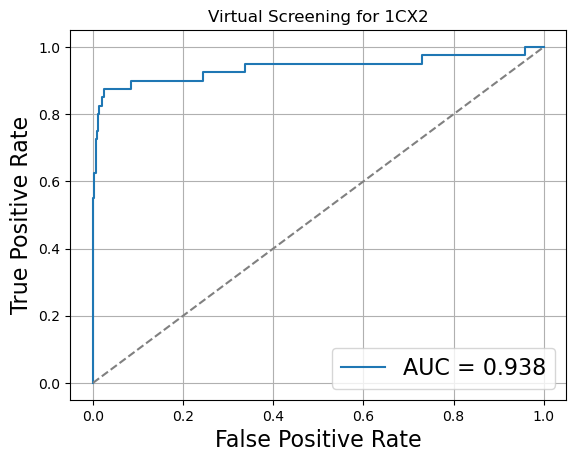

In [11]:
# calculate ROC and AUC
# invert score as negative scores are better
df["score_inv"] = -df["score"] 

#df['scaled_score'] = (df['score_inv'] - df['score_inv'].min()) / (df['score_inv'].max() - df['score_inv'].min())

# calculate fpr, tpr at varying thresholds
fpr, tpr, thresholds = roc_curve(df["label"], df["score_inv"])

# calculate auc 
auc = roc_auc_score(df["label"], df["score_inv"])

# plot ROC
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate", fontsize = 16)
plt.ylabel("True Positive Rate", fontsize = 16)
plt.legend(fontsize = 16)
plt.title(f"Virtual Screening for {receptor}")
plt.grid(True)
plt.savefig(f"{dir}/ROC.png")
plt.show()